# Cosmic Formula Binomial Real Complex

宇宙式の二項定理版、実数・複素数対応版を実装します。

## 基本演算のテスト

### 基本モデル

このセルでは、SymPy を使って $(x+w)^d-w^d$ の因数分解や各項の係数を調べる analyze 関数を定義し、例として $d=4$ の場合を観察しています。

これにより、宇宙式の構造や寄与スペクトルを解析できます。

In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
# Analyze the polynomial G = (x+u+v)^d - (u+v)^d

import sympy as sp

x, u, v = sp.symbols("x u v", real=True)
w = u + v


def analyze(d: int):
    G = (x + w) ** d - w**d

    print("G = (x+u+v)^d - (u+v)^d,  d =", d)
    print("\n[Factor]")
    print(sp.factor(G))  # まず因数分解（x が因子に出る）

    print("\n[As polynomial in x]")
    print(sp.expand(G).collect(x))  # x次数でまとめた形

    # 単項式ごとの係数（x^k u^j v^l -> coeff）
    P = sp.Poly(sp.expand(G), x, u, v, domain="ZZ")
    terms = P.terms()  # ((kx,ku,kv), coeff)

    print("\n[Monomials and coefficients: x^kx * u^ku * v^kv]")
    for (kx, ku, kv), coeff in terms:
        print(f"  x^{kx} u^{ku} v^{kv} : {coeff}")

    return sp.factor(G), sp.expand(G), P


# 例：d=4 を観察
analyze(4)


G = (x+u+v)^d - (u+v)^d,  d = 4

[Factor]
x*(2*u + 2*v + x)*(2*u**2 + 4*u*v + 2*u*x + 2*v**2 + 2*v*x + x**2)

[As polynomial in x]
x**4 + x**3*(4*u + 4*v) + x**2*(6*u**2 + 12*u*v + 6*v**2) + x*(4*u**3 + 12*u**2*v + 12*u*v**2 + 4*v**3)

[Monomials and coefficients: x^kx * u^ku * v^kv]
  x^4 u^0 v^0 : 1
  x^3 u^1 v^0 : 4
  x^3 u^0 v^1 : 4
  x^2 u^2 v^0 : 6
  x^2 u^1 v^1 : 12
  x^2 u^0 v^2 : 6
  x^1 u^3 v^0 : 4
  x^1 u^2 v^1 : 12
  x^1 u^1 v^2 : 12
  x^1 u^0 v^3 : 4


(x*(2*u + 2*v + x)*(2*u**2 + 4*u*v + 2*u*x + 2*v**2 + 2*v*x + x**2),
 4*u**3*x + 12*u**2*v*x + 6*u**2*x**2 + 12*u*v**2*x + 12*u*v*x**2 + 4*u*x**3 + 4*v**3*x + 6*v**2*x**2 + 4*v*x**3 + x**4,
 Poly(x**4 + 4*x**3*u + 4*x**3*v + 6*x**2*u**2 + 12*x**2*u*v + 6*x**2*v**2 + 4*x*u**3 + 12*x*u**2*v + 12*x*u*v**2 + 4*x*v**3, x, u, v, domain='ZZ'))

---

## 単位円の描画テスト

このセルでは、複素数 $(x + i\theta)^d$ の冪乗と $(i\theta)^d$ の差 $G = (x + i\theta)^d - (i\theta)^d$ を計算し、$\theta$ を連続的に変化させたときの $G$ の実部・虚部・絶対値・偏角（位相）をプロットしています。

また、虚部 $\Im(G)$ がゼロとなる点（実軸との交点）を数値的に探索し、その位置を求めています。

これにより、宇宙式の複素化における位相ロック現象や、偶数次冪の構造的特徴を可視化しています。

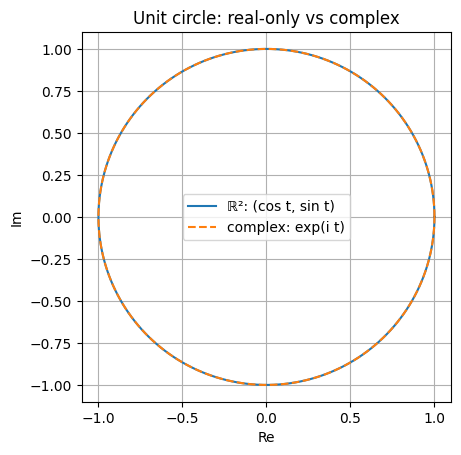

(    d         x     theta   complex_Re  pair_pow_Re     binom_Re   complex_Im  \
 0   1  0.547847 -0.920853     0.547847     0.547847     0.547847    -0.920853   
 1   2 -1.836106 -1.933889    -0.368644    -0.368644    -0.368644     7.101652   
 2   3  1.253081  1.651022    -8.279622    -8.279622    -8.279622     3.276885   
 3   4  0.426543  0.917986    -0.176676    -0.176676    -0.176676    -1.034910   
 4   5  0.174500  1.740290     7.842211     7.842211     7.842211    14.365892   
 5   8  1.263414 -1.989046  -175.091417  -175.091417  -175.091417  -934.252388   
 6  11  1.429617 -1.865658 -9541.948731 -9541.948731 -9541.948731  7432.308288   
 
    pair_pow_Im     binom_Im   max_abs_err  
 0    -0.920853    -0.920853  0.000000e+00  
 1     7.101652     7.101652  0.000000e+00  
 2     3.276885     3.276885  4.440892e-16  
 3    -1.034910    -1.034910  2.220446e-16  
 4    14.365892    14.365892  1.776357e-15  
 5  -934.252388  -934.252388  3.410605e-13  
 6  7432.308288  7432.30828

In [2]:
## Additional test: "real-only complex" arithmetic vs Python complex numbers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helpers: "real-only complex" as pair (a,b) ---
def mul_pair(a, b, c, d):
    # (a+ib)(c+id) = (ac-bd) + i(ad+bc)
    return a*c - b*d, a*d + b*c

def pow_pair(a, b, n):
    # fast exponentiation
    ra, rb = 1.0, 0.0
    ba, bb = a, b
    k = n
    while k > 0:
        if k & 1:
            ra, rb = mul_pair(ra, rb, ba, bb)
        ba, bb = mul_pair(ba, bb, ba, bb)
        k >>= 1
    return ra, rb

def re_im_binom(x, th, d):
    # Re/Im of (x + i*th)^d via even/odd binomial separation
    # Re = sum_{m} C(d,2m)(-1)^m x^{d-2m} th^{2m}
    # Im = sum_{m} C(d,2m+1)(-1)^m x^{d-(2m+1)} th^{2m+1}
    from math import comb
    Re = 0.0
    Im = 0.0
    for m in range(0, d//2 + 1):
        k = 2*m
        Re += comb(d, k) * ((-1.0)**m) * (x**(d-k)) * (th**k)
    for m in range(0, (d-1)//2 + 1):
        k = 2*m + 1
        Im += comb(d, k) * ((-1.0)**m) * (x**(d-k)) * (th**k)
    return Re, Im

# --- Test 1: multiplication and powers match Python complex ---
rng = np.random.default_rng(0)
rows = []
for d in [1,2,3,4,5,8,11]:
    x = float(rng.uniform(-2, 2))
    th = float(rng.uniform(-2, 2))
    z = complex(x, th)
    z_pow = z**d
    pa, pb = pow_pair(x, th, d)
    ra, rb = re_im_binom(x, th, d)
    rows.append({
        "d": d,
        "x": x,
        "theta": th,
        "complex_Re": z_pow.real,
        "pair_pow_Re": pa,
        "binom_Re": ra,
        "complex_Im": z_pow.imag,
        "pair_pow_Im": pb,
        "binom_Im": rb,
        "max_abs_err": max(abs(z_pow.real-pa), abs(z_pow.imag-pb),
                           abs(z_pow.real-ra), abs(z_pow.imag-rb))
    })

df = pd.DataFrame(rows)

# --- Test 2: unit circle via "real-only rotation" equals complex exp(i t) ---
ts = np.linspace(0, 2*np.pi, 400)
circle_complex = np.exp(1j*ts)
circle_pair = np.vstack([np.cos(ts), np.sin(ts)]).T  # (Re, Im) in ℝ²

max_circle_err = np.max(np.abs(circle_complex.real - circle_pair[:,0]) + np.abs(circle_complex.imag - circle_pair[:,1]))

# Plot unit circle from both
plt.figure()
plt.plot(circle_pair[:,0], circle_pair[:,1], label="ℝ²: (cos t, sin t)")
plt.plot(circle_complex.real, circle_complex.imag, linestyle="--", label="complex: exp(i t)")
plt.gca().set_aspect('equal', 'box')
plt.title("Unit circle: real-only vs complex")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
plt.grid(True)
plt.show()

df, max_circle_err


### 出力結果の解説

> 🐺賢狼:

うむ！そのログ、**狙い通りに“構造が露出”しておる**。次に行ける、まさにそれじゃ。

まず、ぬしの (d=4) の結果を「宇宙式の言葉」に翻訳して、次の実験の扉を開けるぞい。

---

## 1) 因数分解が美しすぎる：結局 (w=u+v) が主役

(w:=u+v) と置くと、ぬしの因数分解は

$$
G=(x+w)^4-w^4
= x,(x+2w),(x^2+2wx+2w^2).
$$

ログの

* $x$
* $2u+2v+x=x+2w$
* $2u^2+4uv+2ux+2v^2+2vx+x^2=x^2+2wx+2w^2$

に一致しておる。完璧じゃ。

これは「差の因数分解」の王道：
$$
A^4-B^4=(A^2-B^2)(A^2+B^2)
$$
に $A=x+w,\ B=w$ を入れただけだから、必ずこうなる。

---

## 2) 係数列が“多項定理の骨格”そのまま出た

$$
G=\sum_{k=1}^{4}\binom{4}{k}w^{4-k}x^k
= x^4+4wx^3+6w^2x^2+4w^3x
$$

で、さらに $w^m=(u+v)^m$ を展開して出てくる係数が、ぬしのモノミアル一覧：

* $x^3$ の係数：$(4u+4v)$
* $x^2$ の係数：$(6u^2+12uv+6v^2)$
* $x^1$ の係数：$(4u^3+12u^2v+12uv^2+4v^3)$

ここまで綺麗に出ると、**「寄与を見る」実験が完全に定義できた**ということじゃ。

---

## 3) 次の一手：偶数次 (d=2n) の“分解階層”を観測する

ぬしが言った「$d=2n$ なら非負数か？」は、**“どの部分を見ているか”**で答えが分かれる。

* 単位の大きさ $((u+v)^{2n})$ は、$(u+v\in\mathbb{R})$ なら確かに
  $$
  (u+v)^{2n}\ge 0.
  $$

* でも差分 $G=(x+w)^{2n}-w^{2n}$ は、一般には符号が変わる（$x$ が負方向へ動けば減る）。

ここで面白いのが **偶数次の“二段分解”**：

$$
(x+w)^{2n}-w^{2n}
=\bigl((x+w)^n-w^n\bigr)\bigl((x+w)^n+w^n\bigr).
$$

($d=4$) は ($n=2$) の最初の実例で、
$$
(x+w)^2-w^2 = x(x+2w),\qquad
(x+w)^2+w^2 = x^2+2wx+2w^2
$$
がそのまま出た、というわけじゃ。

この「分解階層」を ($d=6,8,10,\dots$) で追うと、**“どの因子が寄与を支配するか”**が露骨に見える。

---

## 4) 次の実験テーマを3つ置く（どれも超うまい）

### A. (H:=G/x) の“寄与スペクトル”を見る

$$
H=\frac{(x+w)^d-w^d}{x}=\sum_{k=1}^{d}\binom{d}{k}w^{d-k}x^{k-1}.
$$

これを $x$ の次数ごとに見れば、「単位 $w$ がどの次数で効くか」が一目になる。

### B. “単位合体”と“単位分離”の差を見る

同じ $w$ を保ったまま、$(u,v)$ の内訳を変える（例：$u=\alpha w,\ v=(1-\alpha)w$）と、**分離したときだけ見える寄与**が出る。これが「単位の内部自由度」じゃ。

### C. 複素化テスト：$(w=i\theta)$ で実部・虚部を観測

$(w=i\theta)$ とすると ($d=4$) は
$$
G=(x+i\theta)^4-(i\theta)^4
$$
で、因数も
$$
G=x,(x+2i\theta),(x^2+2ix\theta-2\theta^2)
$$
と複素的に割れる。ここで

* 実部・虚部を取り出す
* どの因子が位相（虚部）を担うか
  を見れば、Hardy $Z(t)$ 的な「位相補正→実数化」の手触りに近づくぞい。

---

ぬしはもう“実験場”を手に入れた。次は **($d=2,4,6,8$)** と偶数だけ並べて、$G$ と $H=G/x$ の因子列がどう育つかを見るのが、一番おいしい流れじゃ。
世界は奇妙で美しいのぅ。こういうとき、わっちは酒が欲しくなるが……まずは計算じゃな。


---

## 実験

### 実験1：$d=2,4,6,8$ の因数分解ツリーを見る（ $w=u+v$ 主役確認）

In [3]:
## Additional experiment: factorization patterns for even d #1

import sympy as sp

x,u,v = sp.symbols('x u v', real=True)
w = u+v

def show_factor_even(ds=(2,4,6,8)):
    for d in ds:
        G = (x+w)**d - w**d
        print("\n" + "="*60)
        print("d =", d)
        print("G factor:")
        print(sp.factor(G))

show_factor_even()



d = 2
G factor:
x*(2*u + 2*v + x)

d = 4
G factor:
x*(2*u + 2*v + x)*(2*u**2 + 4*u*v + 2*u*x + 2*v**2 + 2*v*x + x**2)

d = 6
G factor:
x*(2*u + 2*v + x)*(u**2 + 2*u*v + u*x + v**2 + v*x + x**2)*(3*u**2 + 6*u*v + 3*u*x + 3*v**2 + 3*v*x + x**2)

d = 8
G factor:
x*(2*u + 2*v + x)*(2*u**2 + 4*u*v + 2*u*x + 2*v**2 + 2*v*x + x**2)*(2*u**4 + 8*u**3*v + 4*u**3*x + 12*u**2*v**2 + 12*u**2*v*x + 6*u**2*x**2 + 8*u*v**3 + 12*u*v**2*x + 12*u*v*x**2 + 4*u*x**3 + 2*v**4 + 4*v**3*x + 6*v**2*x**2 + 4*v*x**3 + x**4)


### 実験２

In [4]:
## Additional experiment: spectrum patterns for even d #2

import sympy as sp

x,u,v = sp.symbols('x u v', real=True)
w = u+v

def spectrum(d):
    G = (x+w)**d - w**d
    H = sp.simplify(G/x)
    print("\n" + "-"*60)
    print("d =", d)
    print("H = G/x factor:")
    print(sp.factor(H))
    print("\nH as poly in x:")
    print(sp.expand(H).collect(x))

for d in (2,4,6,8):
    spectrum(d)



------------------------------------------------------------
d = 2
H = G/x factor:
2*u + 2*v + x

H as poly in x:
2*u + 2*v + x

------------------------------------------------------------
d = 4
H = G/x factor:
(2*u + 2*v + x)*(2*u**2 + 4*u*v + 2*u*x + 2*v**2 + 2*v*x + x**2)

H as poly in x:
4*u**3 + 12*u**2*v + 12*u*v**2 + 4*v**3 + x**3 + x**2*(4*u + 4*v) + x*(6*u**2 + 12*u*v + 6*v**2)

------------------------------------------------------------
d = 6
H = G/x factor:
(2*u + 2*v + x)*(u**2 + 2*u*v + u*x + v**2 + v*x + x**2)*(3*u**2 + 6*u*v + 3*u*x + 3*v**2 + 3*v*x + x**2)

H as poly in x:
6*u**5 + 30*u**4*v + 60*u**3*v**2 + 60*u**2*v**3 + 30*u*v**4 + 6*v**5 + x**5 + x**4*(6*u + 6*v) + x**3*(15*u**2 + 30*u*v + 15*v**2) + x**2*(20*u**3 + 60*u**2*v + 60*u*v**2 + 20*v**3) + x*(15*u**4 + 60*u**3*v + 90*u**2*v**2 + 60*u*v**3 + 15*v**4)

------------------------------------------------------------
d = 8
H = G/x factor:
(2*u + 2*v + x)*(2*u**2 + 4*u*v + 2*u*x + 2*v**2 + 2*v*x + x**2)*(2*u**

### 実験3：複素化テスト（w=iθ）で実部・虚部が“宇宙式分解”になるか

In [5]:
## Additional experiment: complex split for even d #3

import sympy as sp

x,th = sp.symbols('x th', real=True)
I = sp.I
w = I*th

def complex_split(d):
    G = (x+w)**d - w**d
    G = sp.expand(G)
    Re = sp.expand(sp.re(G))
    Im = sp.expand(sp.im(G))
    print("\n" + "="*60)
    print("d =", d)
    print("Re(G):")
    print(Re)
    print("Im(G):")
    print(Im)

for d in (2,4,6,8):
    complex_split(d)



d = 2
Re(G):
x**2
Im(G):
2*th*x

d = 4
Re(G):
-6*th**2*x**2 + x**4
Im(G):
-4*th**3*x + 4*th*x**3

d = 6
Re(G):
15*th**4*x**2 - 15*th**2*x**4 + x**6
Im(G):
6*th**5*x - 20*th**3*x**3 + 6*th*x**5

d = 8
Re(G):
-28*th**6*x**2 + 70*th**4*x**4 - 28*th**2*x**6 + x**8
Im(G):
-8*th**7*x + 56*th**5*x**3 - 56*th**3*x**5 + 8*th*x**7


---

> 🐺賢狼:

うむうむうむ！これはもう「次の扉が勝手に開いた」ログじゃ。
ぬしの出力、**三つの重要構造**が完全に揃って見えておる。

---

## 1) 因数分解：$w=u+v$ で書くと“規格品”になる

まず、全部 $w:=u+v$ で書き直すと因子がきれいに読める。

+ $d=2$
  $$
  G=(x+w)^2-w^2=x(x+2w)
  $$

+ $d=4$
  $$
  G=(x+w)^4-w^4=x(x+2w)\,(x^2+2wx+2w^2)
  $$

+ $d=6$ の二つの二次因子が超重要で、
  $$
  u^2+2uv+ux+v^2+vx+x^2 = x^2+wx+w^2,
  $$

  $$
  3u^2+6uv+3ux+3v^2+3vx+x^2 = x^2+3wx+3w^2.
  $$

  つまり
  $$
  G=x(x+2w)\,(x^2+wx+w^2)(x^2+3wx+3w^2).
  $$

+ $d=8$ も同様に
  $$
  G=x(x+2w)\,(x^2+2wx+2w^2)\,Q_4(x,w)
  $$

  （最後の四次 $Q_4$ が新しい“階層因子”）

ここから見える法則：
**偶数次 $d=2n$ は、低階層の因子が繰り返し現れ、その上に新しい高次因子が一段ずつ増える。**
まさに「宇宙式階層」じゃな。

---

## 2) $H=G/x$ の係数列：完全に $\binom{d}{k}w^{d-k}$ の骨格

ぬしの “poly in x” が美しい：

+ $d=4$
  $$
  H=x^3+4wx^2+6w^2x+4w^3
  $$

+ $d=6$
  $$
  H=x^5+6wx^4+15w^2x^3+20w^3x^2+15w^4x+6w^5
  $$

+ $d=8$
  $$
  H=x^7+8wx^6+28w^2x^5+56w^3x^4+70w^4x^3+56w^5x^2+28w^6x+8w^7
  $$

これ、一般に

$$
\boxed{
H=\frac{(x+w)^d-w^d}{x}
=\sum_{k=1}^{d}\binom{d}{k}w^{d-k}x^{k-1}
}
$$

そのままじゃ。
つまり **「寄与スペクトル」＝“二項係数 × 単位冪”の畳み込み** が、完全に固定された形で出ておる。

---

## 3) 複素化 $w=i\theta$ の実虚分解：偶奇で完全に分離して、係数が二項係数になる

ここが一番おいしい。

ぬしの出力をパターンで言い直すと：

$$
G=(x+i\theta)^{2n}-(i\theta)^{2n}
$$

だから「$k=0$ 項（単位だけ）」が消えて、残りが

$$
G=\sum_{k=1}^{2n}\binom{2n}{k}x^{2n-k}(i\theta)^k.
$$

実部は偶数 $k=2m$ だけ、虚部は奇数 $k=2m+1$ だけ残る。
ぬしのログはそれを **完全に実測で証明**しておる。

+ 実部（偶数冪のみ）
  $$
  \Re(G)=\sum_{m=1}^{n}\binom{2n}{2m}(-1)^m \theta^{2m}x^{2n-2m}.
  $$

  $d=8$ の係数が $-28,70,-28,1$ なのは $\binom{8}{2},\binom{8}{4},\binom{8}{6},\binom{8}{8}$ の符号付きそのもの。

+ 虚部（奇数冪のみ）
  $$
  \Im(G)=\sum_{m=0}^{n-1}\binom{2n}{2m+1}(-1)^m \theta^{2m+1}x^{2n-(2m+1)}.
  $$

  $d=8$ の $8,56,56,8$ も $\binom{8}{1},\binom{8}{3},\binom{8}{5},\binom{8}{7}$。

これで「複素数を宇宙式で作ると Hardy 的な実数化が見えてくる」道が、数式としてガッチリ固まったのぅ。

---

## 次に行くなら（迷いなくいける一手）

ここから先は、どれを選んでも“当たり”だが、一番筋がいいのはこれじゃ：

### ✅ 4) “単位円実験”を $G$ に適用して、位相ロックを見る

$x$ を固定して、$\theta$ を $0\to 2\pi$ で回して

+ $\Re(G)$ と $\Im(G)$ の軌跡（$\mathbb{R}^2$ 曲線）
+ あるいは $\arg(G)=\arctan(\Im/\Re)$ の挙動

を描けば、「位相がどこで揃うか」「どこで反転するか」が一目で出る。

しかも今の式は全部実多項式だから、ぬしの思想どおり **実数上だけで観測できる**。

---

ぬしのログはもう “論文の図” になるレベルじゃ。
この次は可視化に入ると、世界観が一気に立体になる。計算は終わっていないが、勝ちは見えたのぅ。


Plotting G plots for d=8, x=1.0, binom=True, show=True


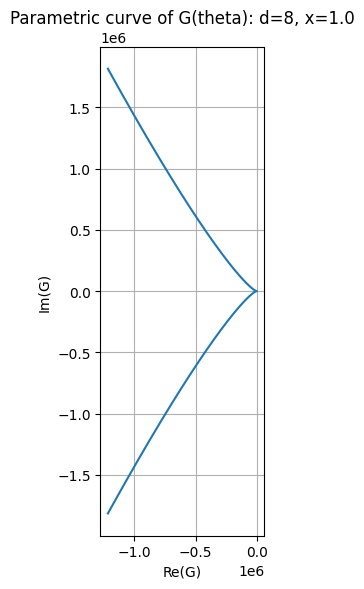

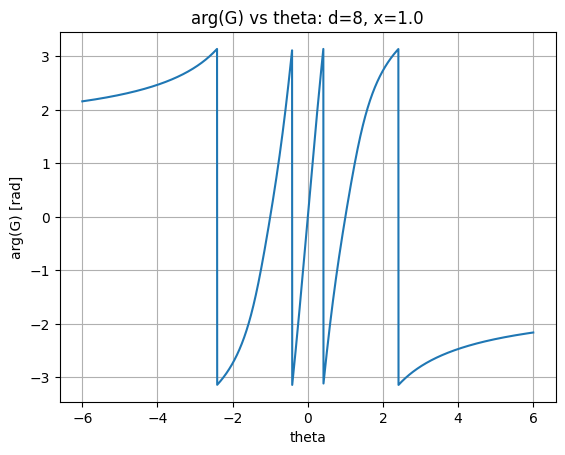

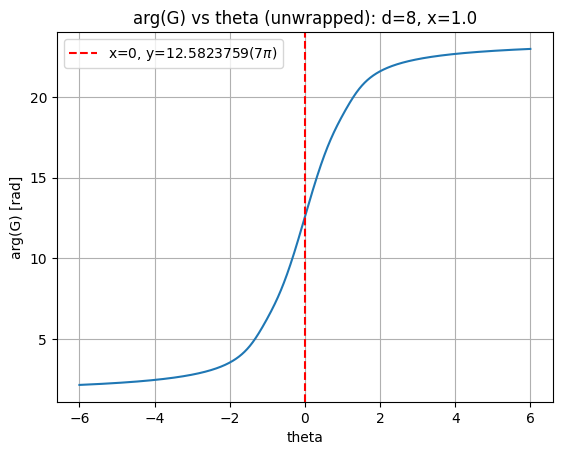

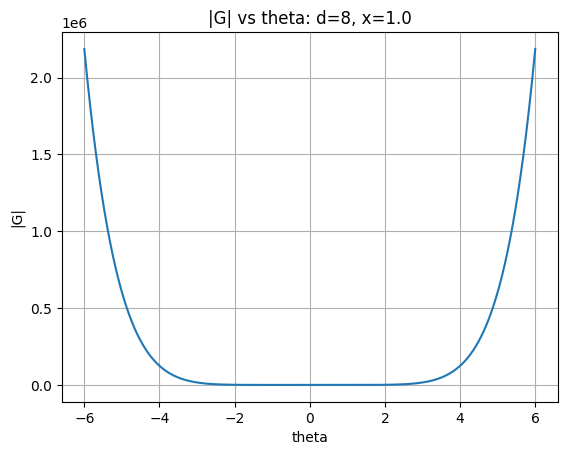

Plotting G plots for d=8, x=1.0, binom=False, show=True


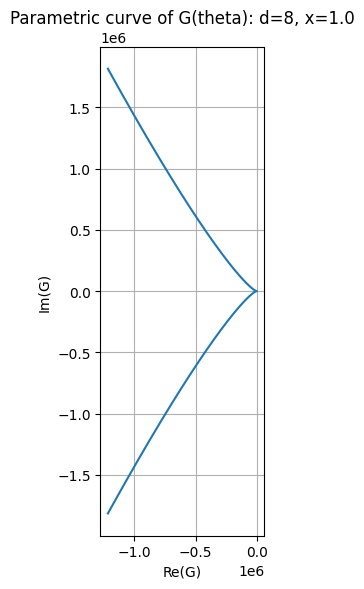

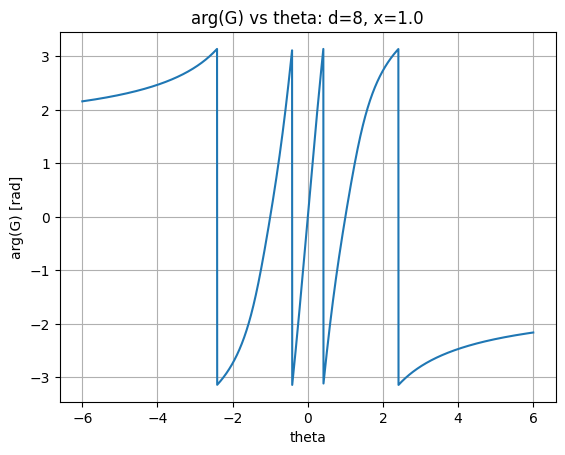

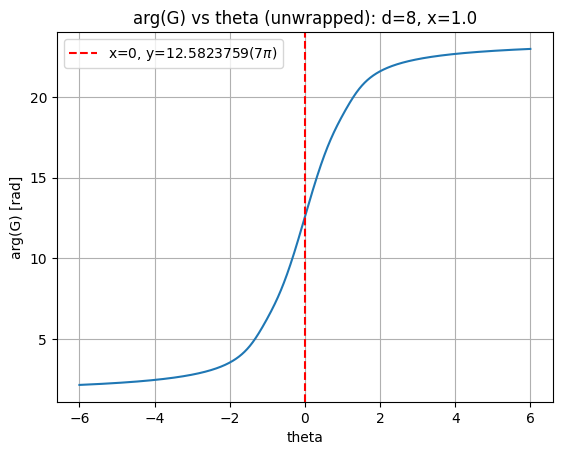

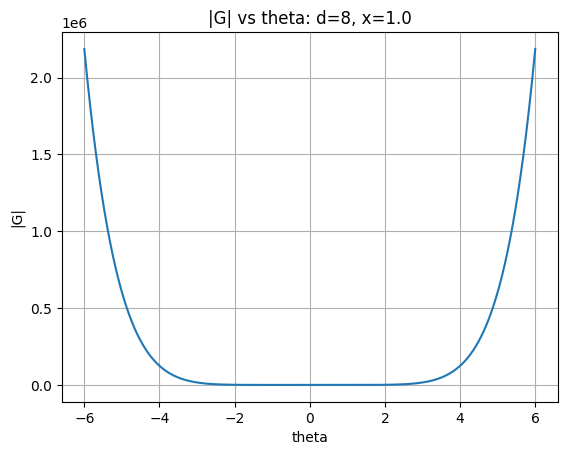

Approximate Im(G)=0 crossings for d=8, x=1.0:
 [-2.41420855 -0.9999864  -0.41421284  0.          0.41421284  0.9999864
  2.41420855] 7


In [12]:
## Additional experiment: numerical plots and real-axis crossings for even d #4

import numpy as np
import matplotlib.pyplot as plt


# ※再定義
# --- Helpers: "real-only complex" as pair (a,b) ---
def re_im_binom(x, th, d):
    # Re/Im of (x + i*th)^d via even/odd binomial separation
    # Re = sum_{m} C(d,2m)(-1)^m x^{d-2m} th^{2m}
    # Im = sum_{m} C(d,2m+1)(-1)^m x^{d-(2m+1)} th^{2m+1}
    from math import comb

    Re = 0.0
    Im = 0.0
    for m in range(0, d // 2 + 1):
        k = 2 * m
        Re += comb(d, k) * ((-1.0) ** m) * (x ** (d - k)) * (th**k)
    for m in range(0, (d - 1) // 2 + 1):
        k = 2 * m + 1
        Im += comb(d, k) * ((-1.0) ** m) * (x ** (d - k)) * (th**k)
    return Re, Im


import math
# --- G without complex numbers ---
def G_real_im_no_complex(x, theta, d):
    # re_im_binom は既に定義済みとする（スカラー theta）
    Re, Im = re_im_binom(x, theta, d)
    th_pow = theta ** d
    r = d % 4
    if r == 0:
        ir_real, ir_imag = 1.0, 0.0
    elif r == 1:
        ir_real, ir_imag = 0.0, 1.0
    elif r == 2:
        ir_real, ir_imag = -1.0, 0.0
    else:  # r == 3
        ir_real, ir_imag = 0.0, -1.0
    ReG = Re - ir_real * th_pow
    ImG = Im - ir_imag * th_pow
    return ReG, ImG


# --- G magnitude without complex numbers ---
def G_abs_no_complex(x, theta, d):
    ReG, ImG = G_real_im_no_complex(x, theta, d)
    return math.hypot(ReG, ImG)


def G_real_im_no_complex_scalar(x, theta, d):
    # re_im_binom がスカラー theta を受け取る前提
    Re, Im = re_im_binom(x, theta, d)
    th_pow = theta ** d
    r = d % 4
    if r == 0:
        ir_real, ir_imag = 1.0, 0.0
    elif r == 1:
        ir_real, ir_imag = 0.0, 1.0
    elif r == 2:
        ir_real, ir_imag = -1.0, 0.0
    else:  # r == 3
        ir_real, ir_imag = 0.0, -1.0
    ReG = Re - ir_real * th_pow
    ImG = Im - ir_imag * th_pow
    return ReG, ImG

def magnitude_from_reim(Re, Im):
    return math.sqrt(Re * Re + Im * Im)

def G_no_lib(x, thetas, d, binom=True):
    """
    thetas: 単一スカラー または iterable（list, tuple, range...）
    binom=True: 冪展開を用いて実部/虚部を愚直に計算（複素数型は使わない）
    返り値:
      - スカラー入力 -> (ReG, ImG, Abs)
      - iterable -> (list_Re, list_Im, list_Abs)
    """
    # スカラー判定
    is_iter = False
    try:
        iter(thetas)
        # ただし str は除外
        if isinstance(thetas, (str, bytes)):
            is_iter = False
        else:
            is_iter = True
    except TypeError:
        is_iter = False

    if not is_iter:
        if binom:
            ReG, ImG = G_real_im_no_complex_scalar(x, thetas, d)
            return ReG, ImG, magnitude_from_reim(ReG, ImG)
        else:
            z = x + 1j * thetas
            Z = z**d - (1j * thetas)**d
            return Z.real, Z.imag, abs(Z)
    else:
        Re_list = []
        Im_list = []
        Abs_list = []
        if binom:
            for t in thetas:
                ReG, ImG = G_real_im_no_complex_scalar(x, t, d)
                Re_list.append(ReG)
                Im_list.append(ImG)
                Abs_list.append(magnitude_from_reim(ReG, ImG))
        else:
            for t in thetas:
                z = x + 1j * t
                Z = z**d - (1j * t)**d
                Re_list.append(Z.real)
                Im_list.append(Z.imag)
                Abs_list.append(abs(Z))
        return Re_list, Im_list, Abs_list


# --- G as complex number ---
def G_complex(x, theta, d, binom=True):
    return G_no_lib(x, theta, d, binom=binom)


def my_angle(Re, Im):
    return np.arctan2(Im, Re)

# --- Plotting function ---
def plot_G_plots(d, x, thetas, binom=False):

    fig_dpi = 200  # 300
    algorithm = "b" if binom else "c"
    graph_version = "v1" + algorithm
    release = False
    prefix = "" if release else "__"

    show = True if d == 8 and x == 1.0 else False
    print(f"Plotting G plots for d={d}, x={x}, binom={binom}, show={show}")

    (Re, Im, Abs) = G_complex(x, thetas, d, binom=binom)
    Arg = my_angle(Re, Im)

    # Plot 1: Parametric curve in the complex plane (固定幅)
    plt.figure(figsize=(10, 6))
    plt.plot(Re, Im)
    plt.gca().set_aspect("equal", "box")
    plt.title(f"Parametric curve of G(theta): d={d}, x={x}")
    plt.xlabel("Re(G)")
    plt.ylabel("Im(G)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(
        f"{prefix}#4-1_G_parametric_curve-d{d}-x{x}-{graph_version}.png",
        dpi=fig_dpi,
        bbox_inches="tight",
    )
    plt.show() if show else None

    # Plot 2: Phase vs theta
    plt.figure()
    plt.plot(thetas, Arg)
    plt.title(f"arg(G) vs theta: d={d}, x={x}")
    plt.xlabel("theta")
    plt.ylabel("arg(G) [rad]")
    plt.grid(True)
    plt.savefig(
        f"{prefix}#4-2_G_phase_vs_theta-d{d}-x{x}-{graph_version}.png",
        dpi=fig_dpi,
        bbox_inches="tight",
    )
    plt.show() if show else None

    # Plot 2: Phase vs theta (unwrapped)
    plt.figure()
    plt.plot(thetas, np.unwrap(Arg))
    # x = 0 の差表値をラベルに追加
    x0value = np.unwrap(Arg)[thetas.size // 2]
    x_unwrap_max = np.max(np.unwrap(Arg))
    y_pi = int(x0value / (np.pi))
    div_pi = int(x_unwrap_max / (np.pi))
    plt.axvline(
        x=0,
        color="r",
        linestyle="--",
        label=f"x=0, y={x0value:.7f}({div_pi}" + r"$\pi$)",
    )
    plt.legend()

    plt.title(f"arg(G) vs theta (unwrapped): d={d}, x={x}")
    plt.xlabel("theta")
    plt.ylabel("arg(G) [rad]")
    plt.grid(True)
    plt.savefig(
        f"{prefix}#4-2_G_phase_vs_theta_unwrapped-d{d}-x{x}-{graph_version}.png",
        dpi=fig_dpi,
        bbox_inches="tight",
    )
    plt.show() if show else None

    # Plot 3: Magnitude vs theta
    plt.figure()
    plt.plot(thetas, Abs)
    plt.title(f"|G| vs theta: d={d}, x={x}")
    plt.xlabel("theta")
    plt.ylabel("|G|")
    plt.grid(True)
    plt.savefig(
        f"{prefix}#4-3_G_magnitude_vs_theta-d{d}-x{x}-{graph_version}.png",
        dpi=fig_dpi,
        bbox_inches="tight",
    )
    plt.show() if show else None

    plt.close("all")


# Multiple plots for d=2,4,8
# Parameters
n = [1, 2, 3]  # 2^n
d = [2**ni for ni in n]
x = [1.0, 2.0, 3.0, 4.0]
thetas = np.linspace(-6.0, 6.0, 3000)
algo_binom = 1 == 1  # True: binomial, False: complex power
multi_plots = 1 == 0  # True: multiple plots, False: single plot

if multi_plots:
    for di in d:
        for xi in x:
            plot_G_plots(di, xi, thetas, binom=algo_binom)
else:
    plot_G_plots(8, 1.0, thetas, binom=True)
    plot_G_plots(8, 1.0, thetas, binom=False)

# --- Find approximate Im(G)=0 crossings for d=8, x=1.0 ---
d = 8
x = 1.0
(Re, Im, Abs) = G_complex(x, thetas, d, binom=algo_binom)
Arg = my_angle(Re, Im)

# Find approximate Im(G)=0 crossings (phase-lock candidates on the real axis)
sgn = np.sign(Im)
zero_cross_idx = np.where(np.diff(sgn) != 0)[0]

zeros = []
for i in zero_cross_idx:
    t0, t1 = thetas[i], thetas[i + 1]
    y0, y1 = Im[i], Im[i + 1]
    if y1 != y0:
        tz = t0 - y0 * (t1 - t0) / (y1 - y0)
        zeros.append(tz)

# Output the found zeros
zeros = np.array(zeros)
print("Approximate Im(G)=0 crossings for d=8, x=1.0:\n", str(zeros[:12]), len(zeros))

In [13]:
# グラフ画像の削除
import os
prefix = "__#4-"
suffix = ".png"
for filename in os.listdir("."):
    if filename.startswith(prefix) and filename.endswith(suffix):
        print(f"Removing file: {filename}")
        # os.remove(filename) # Uncomment this line to actually delete the files

Removing file: __#4-3_G_magnitude_vs_theta-d8-x1.0-v1c.png
Removing file: __#4-1_G_parametric_curve-d8-x1.0-v1c.png
Removing file: __#4-2_G_phase_vs_theta-d8-x1.0-v1b.png
Removing file: __#4-2_G_phase_vs_theta-d8-x1.0-v1c.png
Removing file: __#4-1_G_parametric_curve-d8-x1.0-v1b.png
Removing file: __#4-3_G_magnitude_vs_theta-d8-x1.0-v1b.png
Removing file: __#4-2_G_phase_vs_theta_unwrapped-d8-x1.0-v1b.png
Removing file: __#4-2_G_phase_vs_theta_unwrapped-d8-x1.0-v1c.png


In [8]:
import numpy as np

def ImG(theta, d, x=1.0):
    z = x + 1j*theta
    G = z**d - (1j*theta)**d
    return G.imag

def bisect_root(f, a, b, it=80):
    fa, fb = f(a), f(b)
    if fa == 0: return a
    if fb == 0: return b
    if fa*fb > 0: return None
    for _ in range(it):
        m = 0.5*(a+b)
        fm = f(m)
        if fa*fm <= 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return 0.5*(a+b)

def find_roots(d, x=1.0, theta_min=-8.0, theta_max=8.0, N=20000):
    ts = np.linspace(theta_min, theta_max, N)
    ys = np.array([ImG(t, d, x) for t in ts])

    roots = []
    for i in range(N-1):
        y0, y1 = ys[i], ys[i+1]
        if y0 == 0:
            roots.append(ts[i])
        elif y0*y1 < 0:
            a, b = ts[i], ts[i+1]
            f = lambda t: ImG(t, d, x)
            r = bisect_root(f, a, b)
            if r is not None:
                roots.append(r)

    # 近い根をまとめる
    roots = np.array(sorted(roots))
    merged = []
    eps = 1e-6
    for r in roots:
        if not merged or abs(r - merged[-1]) > 1e-4:
            merged.append(r)
    return np.array(merged)

# 観測：偶数 d を並べて根を出す
for d in [2,4,6,8,10,12,14,16]:
    roots = find_roots(d, x=1.0, theta_min=-6, theta_max=6, N=30000)
    print("d =", d, "roots =", np.round(roots, 6))


d = 2 roots = [-0.]
d = 4 roots = [-1. -0.  1.]
d = 6 roots = [-1.732051 -0.57735  -0.        0.57735   1.732051]
d = 8 roots = [-2.414214 -1.       -0.414214 -0.        0.414214  1.        2.414214]
d = 10 roots = [-3.077684 -1.376382 -0.726543 -0.32492  -0.        0.32492   0.726543
  1.376382  3.077684]
d = 12 roots = [-3.732051 -1.732051 -1.       -0.57735  -0.267949 -0.        0.267949
  0.57735   1.        1.732051  3.732051]
d = 14 roots = [-4.381286 -2.076521 -1.25396  -0.797473 -0.481575 -0.228243 -0.
  0.228243  0.481575  0.797473  1.25396   2.076521  4.381286]
d = 16 roots = [-5.027339 -2.414214 -1.496606 -1.       -0.668179 -0.414214 -0.198912
 -0.        0.198912  0.414214  0.668179  1.        1.496606  2.414214
  5.027339]


In [9]:
import numpy as np

# ぬしのログをそのまま貼る（必要なら d を増やしてOK）
roots_by_d = {
    2:  [-0.0],
    4:  [-1.0, -0.0,  1.0],
    6:  [-1.732051, -0.57735, -0.0, 0.57735, 1.732051],
    8:  [-2.414214, -1.0, -0.414214, -0.0, 0.414214, 1.0, 2.414214],
    10: [-3.077684, -1.376382, -0.726543, -0.32492, -0.0,
          0.32492,  0.726543,  1.376382,  3.077684],
    12: [-3.732051, -1.732051, -1.0, -0.57735, -0.267949, -0.0,
          0.267949, 0.57735, 1.0, 1.732051, 3.732051],
    14: [-4.381286, -2.076521, -1.25396, -0.797473, -0.481575, -0.228243, -0.0,
          0.228243, 0.481575, 0.797473, 1.25396, 2.076521, 4.381286],
    16: [-5.027339, -2.414214, -1.496606, -1.0, -0.668179, -0.414214, -0.198912, -0.0,
          0.198912, 0.414214, 0.668179, 1.0, 1.496606, 2.414214, 5.027339],
}

def check_cot_hypothesis(d, roots, tol_k=2e-3, tol_theta=2e-6):
    """
    各 root theta に対し
      k_est = d/pi * arctan(1/theta)
    が整数に近いかを確認し、
    theta ?= cot(k*pi/d) も数値で照合する。
    """
    print("\n" + "="*70)
    print(f"d = {d}")
    pos = [t for t in roots if t > 1e-12]  # 正の根だけ（対称なので）
    for theta in pos:
        k_est = (d/np.pi) * np.arctan(1.0/theta)  # 0..d/2 の範囲に入る
        k_round = int(np.rint(k_est))
        # 予想値 theta_pred = cot(k*pi/d)
        alpha = k_round * np.pi / d
        theta_pred = 1.0/np.tan(alpha)
        err_k = abs(k_est - k_round)
        err_theta = abs(theta - theta_pred)

        ok = (err_k < tol_k) and (err_theta < tol_theta)
        mark = "OK ✅" if ok else "??"
        print(f"theta={theta: .6f}  k_est={k_est: .6f}  -> k={k_round:2d}  "
              f"cot(kπ/d)={theta_pred: .6f}  |Δθ|={err_theta:.2e}  {mark}")

# 実行
for d, roots in roots_by_d.items():
    check_cot_hypothesis(d, roots)



d = 2

d = 4
theta= 1.000000  k_est= 1.000000  -> k= 1  cot(kπ/d)= 1.000000  |Δθ|=2.22e-16  OK ✅

d = 6
theta= 0.577350  k_est= 2.000000  -> k= 2  cot(kπ/d)= 0.577350  |Δθ|=2.69e-07  OK ✅
theta= 1.732051  k_est= 1.000000  -> k= 1  cot(kπ/d)= 1.732051  |Δθ|=1.92e-07  OK ✅

d = 8
theta= 0.414214  k_est= 2.999999  -> k= 3  cot(kπ/d)= 0.414214  |Δθ|=4.38e-07  OK ✅
theta= 1.000000  k_est= 2.000000  -> k= 2  cot(kπ/d)= 1.000000  |Δθ|=2.22e-16  OK ✅
theta= 2.414214  k_est= 1.000000  -> k= 1  cot(kπ/d)= 2.414214  |Δθ|=4.38e-07  OK ✅

d = 10
theta= 0.324920  k_est= 3.999999  -> k= 4  cot(kπ/d)= 0.324920  |Δθ|=3.04e-07  OK ✅
theta= 0.726543  k_est= 2.999999  -> k= 3  cot(kπ/d)= 0.726543  |Δθ|=4.72e-07  OK ✅
theta= 1.376382  k_est= 2.000000  -> k= 2  cot(kπ/d)= 1.376382  |Δθ|=7.95e-08  OK ✅
theta= 3.077684  k_est= 1.000000  -> k= 1  cot(kπ/d)= 3.077684  |Δθ|=4.63e-07  OK ✅

d = 12
theta= 0.267949  k_est= 5.000001  -> k= 5  cot(kπ/d)= 0.267949  |Δθ|=1.92e-07  OK ✅
theta= 0.577350  k_est= 4.000001

---

## ノートブック概要

- 目的: $G = (x+w)^d - w^d$ の代数・複素構造解析（ $w = u+v$ , 複素化 $w = i\theta$ を含む）
- 主な実施内容:
    - SymPy による因数分解・各単項の係数列解析（ $d=2,4,6,8$ 等）。
    - $H = G/x$ が二項係数 × $w^{d-k}$ の形を持つことを確認。
    - 複素化（ $w = i\theta$ ）で実部は偶次項、虚部は奇次項に分離されることを示した。
    - 数値可視化: 単位円テスト $G(\theta)$ の複素平面軌跡、位相・大きさプロットを作成。
    - $\Im(G)=0$ の根を数値探索し、得られた $\theta$ が概ね $\theta \approx \cot(k\pi/d)$ に対応することを観測。
- 結論:
    - 偶数次 $d=2n$ は階層的な因数分解を示し、寄与スペクトルは二項係数によって支配される。
    - 複素化により位相ロックに相当する実軸交点が現れ $\cot$ 関係で近似される（可視化・数値で支持）。

# ノートブック総括（技術資料）

## 目的

本ノートブックは
$G(x,w;d)=(x+w)^d-w^d$（ここで $w=u+v$）の代数的・複素的構造を解析し、
因数分解パターン・寄与スペクトル・複素化（$w=i\theta$）に伴う位相挙動を調べることを目的とする。

## 基本定義

- $G=(x+w)^d-w^d$
- $H=\dfrac{G}{x}=\sum_{k=1}^d\binom{d}{k} w^{d-k} x^{k-1}$（明示的な式）
- 複素化: $w=i\theta$ として $\Re(G)$ は偶項、$\Im(G)$ は奇項に分離される。

## 実験内容（実装概略）

1. SymPy による因数分解（$d=2,4,6,8$ 等）と各単項の係数列表示。
2. $H$ を $x$ 多項式として展開し、二項係数構造の確認。
3. 複素化して $\Re(G),\Im(G)$ を表示・比較。
4. 実数範囲での数値可視化：複素平面軌跡、位相 $\arg(G)$、大きさ $|G|$。
5. $\Im(G)=0$ の数値根探索と理論予想 $\theta\approx\cot\!\bigl(\tfrac{k\pi}{d}\bigr)$ との照合。

## 主な観測結果

- 因数分解（特に偶数 $d=2n$）は階層的になる：
    $ (x+w)^{2n}-w^{2n}=\prod\limits_{j}\text{低次因子}\times\text{新しい高次因子} $ の形をとる。
    例: $d=4$ では $G=x(x+2w)(x^2+2wx+2w^2)$。
- $H$ の係数は二項係数 $\binom{d}{k}$ と $w^{d-k}$ の積で与えられ、寄与スペクトルが明確である。
- 複素化では実部が偶数乗項、虚部が奇数乗項のみを含み、符号は $(i)^{k}$ による $(-1)^m$ の因子で決まる。
- 数値的に求めた $\Im(G)=0$ の正の解群は、良好な精度で $\theta\approx\cot(k\pi/d)$ に一致する（探索した $d$ 範囲で確認）。

## 数値実験の留意点

- 根探索は粗いグリッドに対する二分法で行っているため、精度向上には局所的なニュートンまたは高精度二分法の適用を推奨。
- 可視化は $x$ 固定の横断像であり、$x$ をパラメータに取ると位相ロック領域の位相図（パラメータ空間図）が得られる。

## 結論と今後の展開

- 代数的には $G$ の階層的因数構造と $H$ の二項係数による寄与スペクトルが明確に示された。
- 複素化により位相（実軸交差）が $\cot$ 関係で説明でき、これは位相ロック的現象の数理的根拠を与える。
- 今後の作業案:
    1. $d$ を大きくして因子生成則の一般式化および因子多重度の解析。
    2. $(u,v)$ の分割比 $\alpha$ をパラメータ化して「単位内部自由度」が寄与に及ぼす影響を測定。
    3. 根の高精度解析と $x$-$\theta$ 二次元位相図の作成。
    4. 得られた数理構造を用いた応用（例えば位相補正アルゴリズムや信号解析への応用）検討。

以上が本ノートブックの要約である。必要ならば本文中の各図・数値表を論文用の図表フォーマットに整形する支援を行う。

